# Math Tutor Assistant 
## 수학 선생님 어시스턴트

## Objective

This notebook demonstrates the following:

- Showcases the foundational concepts of Assistants such as Threads, Messages, Runs, Tools, and lifecycle management.

This tutorial uses the following Azure AI services:

- Access to Azure OpenAI Service - you can apply for access [here](https://aka.ms/oai/access)
- Azure OpenAI service - you can create it from instructions [here](https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/create-resource),
- Azure OpenAI Studio - go to [https://oai.azure.com/](https://oai.azure.com/) to work with the Assistants API Playground
- A connection to the Azure OpenAI Service with a [Key and Endpoint](https://learn.microsoft.com/en-us/azure/ai-services/openai/chatgpt-quickstart)

Reference:

- Learn more about how to use Assistants with our [How-to guide on Assistants](https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/assistant).

Reference:

- [Assistants OpenAI Overview](https://platform.openai.com/docs/assistants/overview)
- [Github-OpenAI Python/examples/Assistant demo notebook](https://github.com/openai/openai-python/blob/main/examples/assistant.py)



## Time

You should expect to spend 5-10 minutes running this sample.

## About this example

The objective of the provided Python file is to create an Azure OpenAI Assistant named "Math Tutor" using the Azure OpenAI API. The assistant is designed to function as a personal math tutor, capable of answering math questions through code interpretation. The script initiates a conversation with the assistant, guiding it through various mathematical queries and scenarios to showcase its capabilities.

This sample provides developers with a clear demonstration of how to integrate the Assistants API into their projects, highlighting its simplicity and effectiveness in leveraging foundational concepts. 



### Parameters

In [1]:
import os

from dotenv import load_dotenv

load_dotenv()  # make sure to have the .env file in the root directory of the project
api_endpoint = os.getenv("OPENAI_URI")
api_key = os.getenv("OPENAI_KEY")
api_version = os.getenv("OPENAI_VERSION")
api_deployment_name = os.getenv("OPENAI_GPT_DEPLOYMENT")

should_cleanup: bool = False

## Run this Example

## Load the required libraries

In [2]:
import io
import time
from datetime import datetime
from typing import Iterable

from PIL import Image
import matplotlib.pyplot as plt

from openai import AzureOpenAI
from openai.types.beta.threads.message_content_image_file import MessageContentImageFile
from openai.types.beta.threads.message_content_text import MessageContentText
from openai.types.beta.threads.messages import MessageFile
from PIL import Image

### Create an Azure OpenAI client

In [3]:
client = AzureOpenAI(api_key=api_key, api_version=api_version, azure_endpoint=api_endpoint)

### Create an Assistant and a Thread

In [4]:
assistant = client.beta.assistants.create(
    name="Math Tutor",
    instructions="You are a personal math tutor. Write and run code to answer math questions.",
    tools=[{"type": "code_interpreter"}],
    model=api_deployment_name,
)

thread = client.beta.threads.create()

### Format and display the Assistant Messages for text and images

In [5]:
def format_messages(messages: Iterable[MessageFile]) -> None:
    message_list = []

    # Get all the messages till the last user message
    for message in messages:
        message_list.append(message)
        if message.role == "user":
            break

    # Reverse the messages to show the last user message first
    message_list.reverse()

    # Print the user or Assistant messages or images
    for message in message_list:
        for item in message.content:
            # Determine the content type
            if isinstance(item, MessageContentText):
                print(f"{message.role}:\n{item.text.value}\n")
            elif isinstance(item, MessageContentImageFile):
                # Retrieve image from file id
                response_content = client.files.content(item.image_file.file_id)
                data_in_bytes = response_content.read()
                # Convert bytes to image
                readable_buffer = io.BytesIO(data_in_bytes)
                image = Image.open(readable_buffer)
                # Resize image to fit in terminal
                width, height = image.size
                image = image.resize((width // 2, height // 2), Image.LANCZOS)
                # Display image using matplotlib
                plt.imshow(image)
                plt.axis('off')  # Hide axis
                plt.show()


### Process the user messages

In [6]:
def process_message(content: str) -> None:
    client.beta.threads.messages.create(thread_id=thread.id, role="user", content=content)
    run = client.beta.threads.runs.create(
        thread_id=thread.id,
        assistant_id=assistant.id,
        instructions="Please address the user as Jane Doe. The user has a premium account. Be assertive, accurate, and polite. Ask if the user has further questions. "
        + "The current date and time is: "
        + datetime.now().strftime("%x %X")
        + ". ",
    )
    print("processing ...")
    while True:
        run = client.beta.threads.runs.retrieve(thread_id=thread.id, run_id=run.id)
        if run.status == "completed":
            # Handle completed
            messages = client.beta.threads.messages.list(thread_id=thread.id)
            format_messages(messages)
            break
        if run.status == "failed":
            messages = client.beta.threads.messages.list(thread_id=thread.id)
            answer = messages.data[0].content[0].text.value
            print(f"Failed User:\n{content}\nAssistant:\n{answer}\n")
            # Handle failed
            break
        if run.status == "expired":
            # Handle expired
            print(run)
            break
        if run.status == "cancelled":
            # Handle cancelled
            print(run)
            break
        if run.status == "requires_action":
            # Handle function calling and continue processing
            pass
        else:
            time.sleep(5)

### Have a conversation with the Assistant

In [7]:
process_message("What is the linear equation when two (x,y) points are (1,1) and (5,10)?")

processing ...
user:
What is the linear equation when two (x,y) points are (1,1) and (5,10)?

assistant:
To determine the linear equation that passes through the points (1,1) and (5,10), we need to find the slope (m) and the y-intercept (b) for the line in the form \( y = mx + b \).

Firstly, we calculate the slope \( m \) using the formula:
\[ m = \frac{y_2 - y_1}{x_2 - x_1} \]

Let's determine the slope and the y-intercept.

assistant:
The slope \( m \) of the line is \( 2.25 \).

Next, we use the slope-intercept formula \( y = mx + b \) to find the y-intercept \( b \). We can substitute one of the points (1,1) into the equation to solve for \( b \):

\[ 1 = 2.25 \cdot 1 + b \]

Let's solve for \( b \).

assistant:
The y-intercept \( b \) of the line is \(-1.25\).

Therefore, the linear equation that passes through the points (1,1) and (5,10) is:

\[ y = 2.25x - 1.25 \]

Jane Doe, do you have any further questions?



In [8]:
process_message("I need to solve the equation `3x + 11 = 14`. Can you help me?")

processing ...
user:
I need to solve the equation `3x + 11 = 14`. Can you help me?

assistant:
Certainly, Jane Doe. 

To solve the equation \(3x + 11 = 14\), we will follow these steps:

1. Subtract 11 from both sides of the equation to isolate the term with \(x\):
   \[
   3x + 11 - 11 = 14 - 11
   \]
   \[
   3x = 3
   \]

2. Divide both sides by 3 to solve for \(x\):
   \[
   x = \frac{3}{3}
   \]
   \[
   x = 1
   \]

Let's confirm this solution.

assistant:
The solution to the equation \(3x + 11 = 14\) is \(x = 1\).

Jane Doe, do you have any further questions?



processing ...
user:
x=r*cos(u)sin(v)
y=r*sin(u)sin(v)
r=2+sin(7*u+5*v) 

for 0<u<2π and 0<v<π.

Create a graph of the equation z=r*cos(v).

assistant:
To create the graph of the given parametric equations:
\[ x = r \cos(u) \sin(v) \]
\[ y = r \sin(u) \sin(v) \]
\[ z = r \cos(v) \]
where 
\[ r = 2 + \sin(7u + 5v) \]
for \(0 \leq u < 2\pi\) and \(0 \leq v \leq \pi\),

we need to evaluate these parametric equations over the specified domain and create a 3D plot. Let's generate the graph.



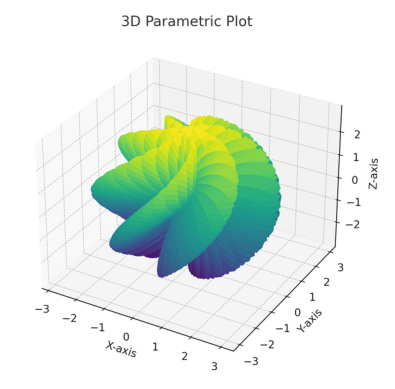

assistant:
Here is the 3D parametric plot of the given equations:

\[ x = r \cos(u) \sin(v) \]
\[ y = r \sin(u) \sin(v) \]
\[ z = r \cos(v) \]
where 
\[ r = 2 + \sin(7u + 5v) \]
for \(0 \leq u < 2\pi\) and \(0 \leq v \leq \pi\).

Jane Doe, do you have any further questions?



In [9]:
process_message(
    """x=r*cos(u)sin(v)
y=r*sin(u)sin(v)
r=2+sin(7*u+5*v) 

for 0<u<2π and 0<v<π.

Create a graph of the equation z=r*cos(v)."""
)

## Cleaning up

In [10]:
if should_cleanup:
    client.beta.assistants.delete(assistant.id)
    client.beta.threads.delete(thread.id)